# Amazon SageMaker XGBoost를 이용한 다이렉트 마케팅 타게팅 
(정기 예금가입 예측)

_**Gradient Boosted Trees를 이용하는 지도학습: 편향된 클래스의 이진 분류 예측문제 해결 **_

---

본 노트북은 다음 소스를 한글로 번역하고 일부 코드를 수정하였습니다. 
-  https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_direct_marketing/xgboost_direct_marketing_sagemaker.ipynb 

---

## 목차

1. [배경](#배경)
1. [준비](#준비)
1. [데이터](#데이터)
    1. [탐험](#탐험)
    1. [변형](#변형)
1. [학습](#학습)
1. [호스팅](#호스팅)
1. [평가](#평가)
1. [확장](#확장)

---

## 배경
메일, 이메일, 전화 등을 이용하는 다이렉트 마케팅은 고객을 모객하는 일반적인 방법입니다. 우리의 자원과 고객의 시간이 제한적이므로 우리는 특정 제안에 참여할 가능성이 높은 고객의 서브그룹에 포키싱할 필요가 있습니다. 인구통계정보나 과거 상호작용, 환경요인 등을 고려하여 이런 잠재고객을 예측하는 것은 머신러닝의 일반적인 문제입니다. 

본 노트북은 한 번 또는 그 이상의 전화요청으로 고객이 은행 정기예금(term deposit)에 가입할 지를 예측하는 문제 사례입니다. 진행 단계는 다음과 같습니다.

* Amazon SageMaker notebook을 준비합니다.
* 인터넷에서 Amazon SageMaker로 데이터를 다운로드합니다.
* 데이터를 조사하고 SageMaker 알고리즘에서 사용할 수 있도록 변형합니다.
* Gradient Boosting 알고리즘을 이용하여 모델을 학습합니다.
* 모델의 성능을 검증합니다.
* 앞으로의 예측에 모델을 적용합니다.


---

## 준비

_본 노트북은 ml.m4.xlarge 인스턴스에서 테스트되었습니다._

다음을 정의합니다.
Let's start by specifying:

- S3 버킷과 prefix : 노트북 인스턴스, 학습, 호스팅 인스턴스와 동일한 리전에 있어야 합니다. 
- IAM 역할(role) arn : 학습, 호스팅작업이 데이터에 접근할 때 사용합니다. 

In [1]:
# !pip install -U sagemaker

In [1]:
import sagemaker
sagemaker.__version__

'2.183.0'

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
prefix = 'sagemaker/DEMO-xgboost-dm'           # prefix used for all data stored within the bucket
bucket

'sagemaker-us-east-1-858740466878'

In [3]:
# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

분석과정에서 필요한 파이썬 라이브러리를 로드합니다.

In [4]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
# from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

---

## 데이터
[direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) 데이터를 다운로드합니다.

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014




In [5]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!apt-get install unzip -y
!unzip -o bank-additional.zip

--2023-09-21 05:20:04--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.153.65, 52.92.180.234, 52.218.192.17, ...
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.153.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip’

100%[======================================>] 432,828     1.57MB/s   in 0.3s   

2023-09-21 05:20:05 (1.57 MB/s) - ‘bank-additional.zip’ saved [432828/432828]

/bin/sh: apt-get: command not found
Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: bank-additiona


pandas 데이터프레임으로 로드하고 내용을 살펴봅니다.

In [6]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


데이터를 살펴봅니다. 대략적으로 다음 내용이 눈에 띕니다.
Let's talk about the data.  At a high level, we can see:

* 3만건 이상의 고객 레코드가 있고 각 고객에 대하여 20건의 속성값(feature)이 습니다.
* 속성은 숫자 또는 명목형(categorical) 값이 섞여 있습니다.
* 데이터는 `time`과 `contact` 등에 따라 정렬된 것처럼 보입니다. 

_**속성 정보:**_

*인구통계정보:*
* `age`: 고객의 나이 (numeric)
* `job`: 직업군 (categorical: 'admin.', 'services', ...)
* `marital`: 결혼여부 (categorical: 'married', 'single', ...)
* `education`: 학업 (categorical: 'basic.4y', 'high.school', ...)

*과거 고객 이벤트:*
* `default`: dafault 여부? (categorical: 'no', 'unknown', ...)
* `housing`: 주택대출 여부? (categorical: 'no', 'yes', ...)
* `loan`: 개인대출 여부? (categorical: 'no', 'yes', ...)

*과거 다이렉트 마케팅 이력:*
* `contact`: 커뮤니케이션 유형 (categorical: 'cellular', 'telephone', ...)
* `month`: 최종 접촉 월 (categorical: 'may', 'nov', ...)
* `day_of_week`: 최종 접촉 주 (categorical: 'mon', 'fri', ...)
* `duration`: 최종 접촉 기간(초) (numeric). 중요: duration 이 0 이면 `y`는 'no'임.
 
*캠페인 정보:*
* `campaign`: 이번 캠페인 동안 접촉한 회수 (numeric, includes last contact)
* `pdays`: 이전 캠페인에서 접촉한 마지막 날짜 이후 경과 시간(일) (numeric)
* `previous`: 이번 캠페인 이전에 고객과의 접촉 회수 (numeric)
* `poutcome`: 이전 캠페인의 성과 (categorical: 'nonexistent','success', ...)

*외부 환경 요인:*
* `emp.var.rate`: 고용 변화율(Employment variation rate, quarterly) (numeric)
* `cons.price.idx`: 소비자 가격 지수(Consumer price index, monthly) (numeric)
* `cons.conf.idx`: 고객 확신 지수 (Consumer confidence index, monthly) (numeric)
* `euribor3m`: Euribor 3 개월 비율 (daily) (numeric)
* `nr.employed`: 고용자 수(Number of employees, quarterly) (numeric)

*타겟 변수:*
* `y`: 고객이 정기예금에 가입하였는가? (binary: 'yes','no')

### 탐험
데이터 탐험(EDA)를 해봅니다. 첫번째로 속성의 분포를 살펴봅니다. 

In [1]:
# https://freedata.tistory.com/60
# pd.crosstab
# Compute a simple cross tabulation of two (or more) factors.

# import pandas as pd
# import numpy as np

# a = ['2/18', '2/18', '2/18', '2/18', '2/20', '2/20', '2/20', '2/20', '2/25', '2/25', '2/25']
# b = ['철수', '철수', '철수', '영희', '영희', '영희', '영희', '철수', '영희', '영희', '철수']
# c = ['치킨', '피자', '닭발', '치킨', '닭발', '짜장면', '피자', '치킨', '피자', '치킨', '피자']
# d = [1,2,1,3,4,4,2,5,3,1,3]

# data = pd.DataFrame({'날짜':a,'사람':b,'음식':c,'개수':d})
# data

,날짜,사람,음식,개수
0,2/18,철수,치킨,1
1,2/18,철수,피자,2
2,2/18,철수,닭발,1
3,2/18,영희,치킨,3
4,2/20,영희,닭발,4
5,2/20,영희,짜장면,4
6,2/20,영희,피자,2
7,2/20,철수,치킨,5
8,2/25,영희,피자,3
9,2/25,영희,치킨,1


In [2]:
# pd.crosstab(index = [data.사람, data.음식], columns = data.날짜)

날짜      2/18  2/20  2/25
사람 음식                   
영희 닭발      0     1     0
   짜장면     0     1     0
   치킨      1     0     1
   피자      0     1     1
철수 닭발      1     0     0
   치킨      1     1     0
   피자      1     0     1

col_0,% observations
job,
admin.,0.253035
blue-collar,0.224677
entrepreneur,0.035350
housemaid,0.025736
management,0.070992
retired,0.041760
self-employed,0.034500
services,0.096363
student,0.021244


col_0,% observations
marital,
divorced,0.111974
married,0.605225
single,0.280859
unknown,0.001942


col_0,% observations
education,
basic.4y,0.101389
basic.6y,0.055647
basic.9y,0.146766
high.school,0.231014
illiterate,0.000437
professional.course,0.127294
university.degree,0.295426
unknown,0.042027


col_0,% observations
default,
no,0.791201
unknown,0.208726
yes,0.000073


col_0,% observations
housing,
no,0.452122
unknown,0.024036
yes,0.523842


col_0,% observations
loan,
no,0.824269
unknown,0.024036
yes,0.151695


col_0,% observations
contact,
cellular,0.634748
telephone,0.365252


col_0,% observations
month,
apr,0.063902
aug,0.149995
dec,0.004419
jul,0.174177
jun,0.129115
mar,0.013256
may,0.334296
nov,0.099568
oct,0.017432


col_0,% observations
day_of_week,
fri,0.190031
mon,0.206711
thu,0.209357
tue,0.196416
wed,0.197485


col_0,% observations
poutcome,
failure,0.103234
nonexistent,0.863431
success,0.033335


col_0,% observations
y,
no,0.887346
yes,0.112654


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


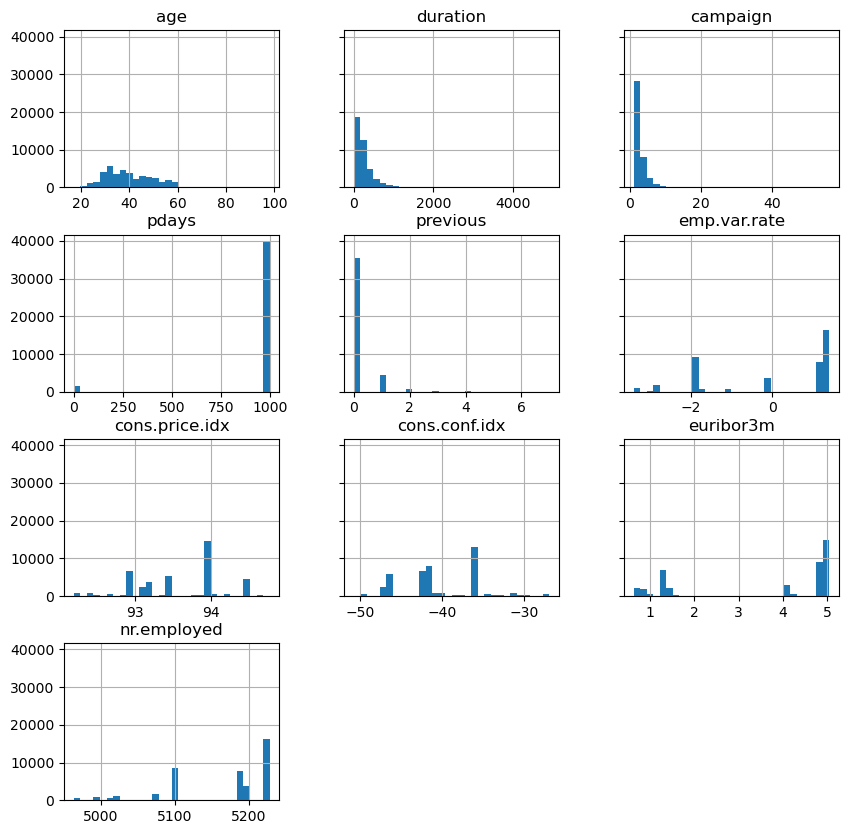

In [7]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:  # 문자열을 포함하는 컬럼만 추출
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

다음을 생각해 볼 수 있습니다.:

* `y`값의 약 90%가 "no"입니다. 곧, 대부분의 고객은 정기예금에 가입하지 않았습니다.
* 많은 속성값이 "unknown"상태이고 그 분포는 속성에 따라 다릅니다. "unknown"상태를 다룰 때 해당 값의 원인이 무엇일 지 어떻게 다루어야 할 지 주의가 필요합니다.
    * "unknown"이 고유한 카테고리를 가지고 있지만 실제로는 발생 원인에 따라 다른 카테고리중 하나에 포함될 것입니다.
* 속성들이 소수의 관찰값을 보유한 카테고리를 가지고 있는 경우가 많습니다. 만약 어떤 작은 카테고리의 속성이 타겟값에 높은 영향을 미친다면, 이를 일반화할 수 있을 정도로 충분히 많은 수의 데이터 샘플(evidence)을 가지고 있나요?
* 접촉 타이밍 정보가 과도하게 치우쳐(skewed) 있습니다. 약 1/3이 5월에 이루어졌으며 12월은 1%미만입니다. 우리가 만약 다음 12월에 대한 예측을 실행한다면 이것이 어떤 의미를 가질까요?
* 숫자형 데이터에 결측치는 없습니다. 결측값은 이미 보정된 상태입니다.
    * `pdays`는 대부분의 고객들에 대하여 1000이 넘습니다. 이전 컨택이 많지 않았음을 알려줍니다.
* 일부 숫자형 속성은 긴 롱테일을 가지고 있습니다. 속성의 주요 부분과 롱테일 부분을 분리해서 접근해야 할 필요가 있나요?
* 일부 숫자형 속성(특히 외부 시장지표 값들)은 몇가지 그룹으로 나누어질 수 있어 보입니다. 이들을 명목형 변수로 바꾸어야 할까요?

다음은, 이들 속성들이 예측하고자 하는 타겟값과 어떻게 관련되는지 살펴봅니다.

y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


age


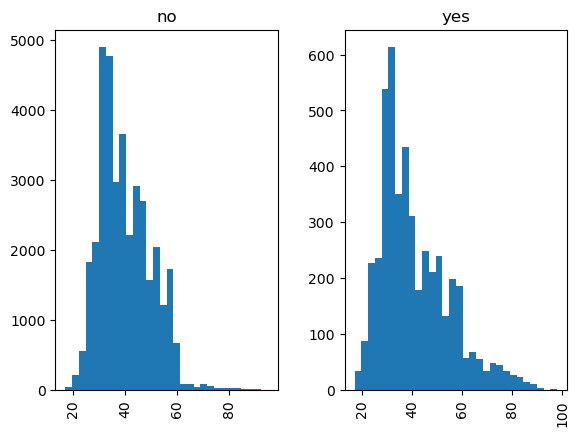

duration


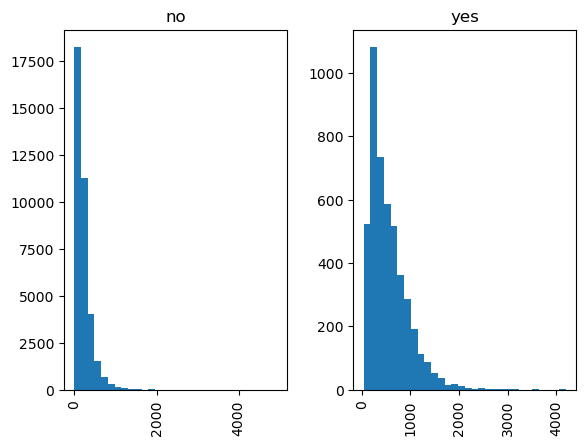

campaign


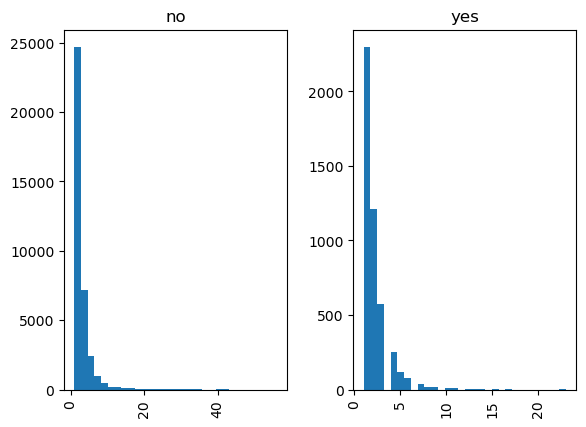

pdays


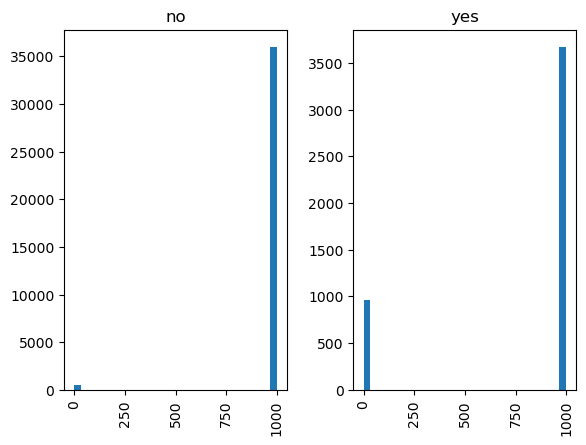

previous


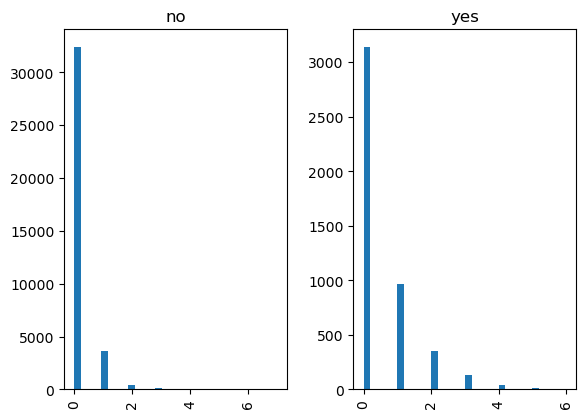

emp.var.rate


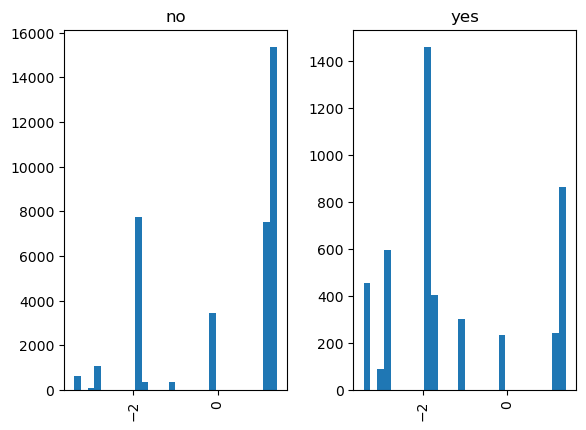

cons.price.idx


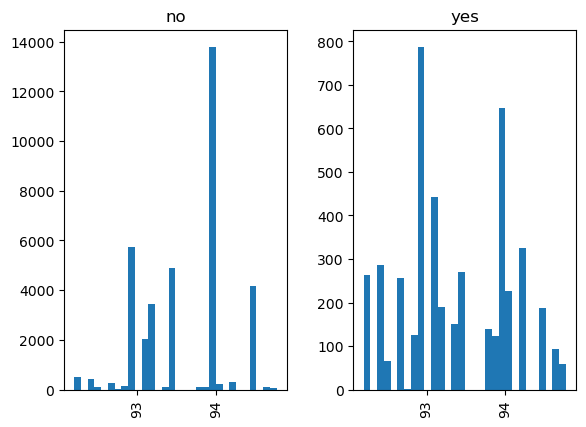

cons.conf.idx


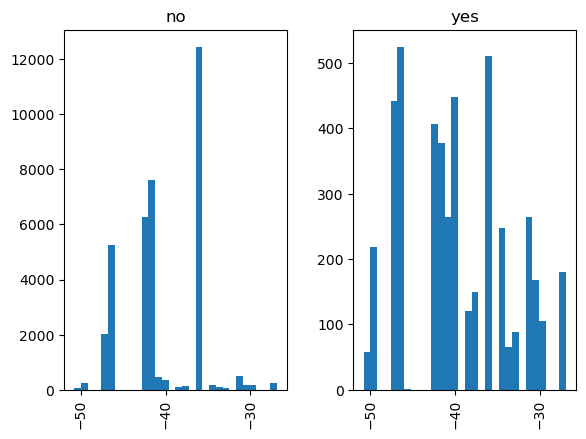

euribor3m


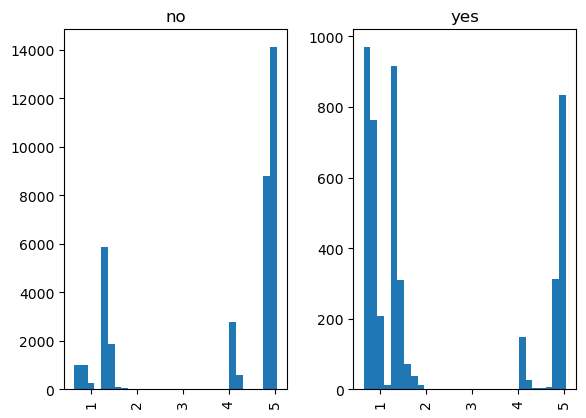

nr.employed


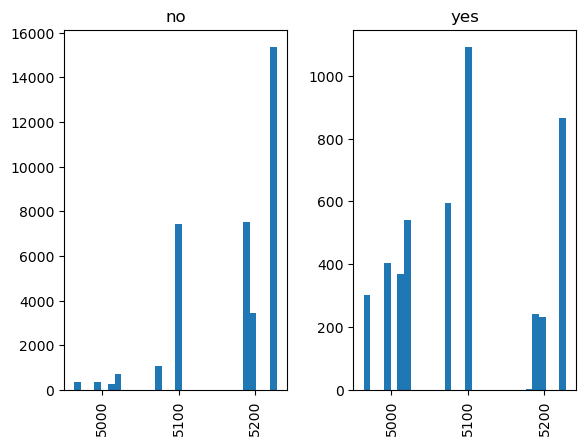

In [9]:
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

다음을 확인할 수 있습니다.

* "blue-collar", "married", 디폴트 여부가 "unknown"인 사용자가 "telephone"으로 "may" 시점에 연락되었다면 정기예금 가입에 매우 적은 "yes"결과를 얻었을 것입니다.
* 숫자형 변수값의 분포는 정기예금 가입 "yes", "no"여부에 따라 다르지만 그 관계가 명확하지는 않습니다. 

다음은 속성들이 서로 어떻게 연관되는지 살펴봅니다.



In [10]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [11]:
# display(data.corr())
# pd.plotting.scatter_matrix(data, figsize=(12, 12))   # 산점도 행렬
# # https://rfriend.tistory.com/416
# plt.show()

Notice that:
다음을 확인할 수 있습니다.

* 속성간 상호 연관성은 다양합니다. 일부는 매우 음의 상관관계를, 또 다른 일부는 양의 상관관계를 보여줍니다. 
* 속성간의 관계는 대부분 비선형이며, 연관성이 크지 않습니다.

### 변형

데이터 클린징은 대부분의 머신러닝 프로젝트에서 필요한 작업입니다. 이 작업은 적절히 수행되지 않으면 결과에 악영향을 끼치며, 주관적인 판단이 많이 개입됩니다. 몇가지 일반적인 기술들은 다음과 같습니다.

* 결측치의 처리 : 일부 머신러닝 알고리즘은 결측치를 처리할 수 있는 경우도 있지만 대부분은 그렇지 않습니다. 이를 처리하는 옵션은:
    * 결측값 제거 : 결측값이 매우 일부분일 경우 적용합니다.
    * 결측속성 제거 : 다량의 결측값을 가지는 속성이 일부분일 경우 적용합니다.
    * 결측값 채우기(imputing) : 다음 책[books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) 전체에서 이 주제에 대해 다루고 있습니다. 일반적인 선택은 결측값을 해당 속성의 다른 값들의 평균이나 최빈값(mode)으로 대체하는 것입니다.
* 명목형(categorical) 속성을 수치형 속성으로 변환 : 가장 일반적인 방법은 원 핫 인코딩(one hot encoding)이라 불리는, 각 명목값들을 컬럼으로 정의한 후 해당값에 매칭되는 여부에 따라 1 또는 0의 값을 가지도록 변환하는 것입니다.
* 분포가 고르지 않은 데이터 : Gradient Boosted Trees와 같은 비선형 모델에서도 좋지 않은 영향을 가져오며, 회기(regression)와 같은 파라미터 방식에서도 과도하게 편향된 데이터는 정확도가 떨어지는 결과를 리턴할 수 있습니다. 간혹 로그(log)값을 취하는 것으로 충분히 정규분포로 변환하는 경우도 있고 개별 범위로 구분하여 명목형 번수로 변환한 후 다시 원 핫 인코딩으로 적용할 수도 있습니다.
* 보다 복잡한 데이터 타입 처리 : 본 노트북에서 다루지는 않지만 이미지, 텍스트, 또는 다양한 grain을 가지는 데이터들에 대해서도 추가 변형이 필요합니다. 

다행히 이들 중 일부는 이미 처리되어 있습니다. 그리고 지금 우리가 다루려고 하는 알고리즘은 드문드문하거나(sparce) 분포가 일정하지 않은 경우에도 잘 동작하는 경향이 있습니다. 따라서 본 예제에서는 최소한의 전처리만 하겠습니다.


In [12]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)                                                                  # Convert categorical variables to sets of indicators
# https://numpy.org/doc/stable/reference/generated/numpy.in1d.html
# np.in1d: 1차원 배열의 각 요소가 두 번째 배열에도 있는지 테스트합니다.

모델을 만들기 전에 필요한 또 다른 질문은 특정 속성이 최종 목표에 기여를 하는지 여부입니다. 예를 들어, 최선의 예측을 제공하는 것이 목표인 경우, 예측을 하려는 시점에 해당 데이터를 사용가능한 지 생각해 봅니다. 우산 판매의 예측에서 비가 올지 여부를 안다면 판매예측에서 매우 유리할 것이지만, 미래의 날씨를 예측하는 것은 날씨 정보 없이 우산판매를 예측하는 것보다 더 어려울 수 있습니다. 이런 경우 과거 날씨정보가 모델의 속성에 포함된다면 정확성을 왜곡할 수도 있습니다. 

이런 논리로, 데이터의 속성들 중 미래에 대한 예측이 필요한 경제 지표들과 `duration`부분을 제외하겠습니다.

이전 분기의 경제 지표 값을 사용할 수도 있겠지만, 이 값들은 실제 업무환경에서는 현실성이 없을 가능성이 높습니다.

In [13]:
# 불필요한 컬럼 삭제
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

모델을 만들 때 1차적인 목표는 새로운 데이터에 대한 타겟변수 값을 예측하는 것이며, 이 때 과적합(overfitting)을 이해하는 것이 중요합니다. 지도학습(Supervised learning) 모델은 타겟변수 값에 대한 실제값과 모델의 예측값 사이의 차이(error)를 최소하는 방식으로 설계됩니다. 이 마지막 부분이 중요합니다. 종종 머신러닝 모델은 보다 높은 정확도를 찾는 과정에서 자신이 본 데이터들만에 대한 사소한 특징들까지 고려하는 편중(bias)를 가지게 됩니다. 이런 특징이 새로운 데이터에서 반복적으로 나타나지 않을 경우 실제 예측에서는 정확도가 떨어지게 되고 학습과정에서의 정확도 수준을 보이지 않게 됩니다.   

이를 예방하는 가장 일반적인 방법은 모델이 학습을 할 때 학습데이터 뿐 아니라 새로운 데이터에 대해서도 적합성을 함께 판단하도록 하는 것이며 홀드아웃 검증(holdout validation), 교차검증(cross-validation), 일회성 검증(leave-one-out validation) 등 여러가지 방식이 있습니다. 본 예제에서는 단순히 랜덤하게 3개의 그룹으로 데이터를 나눌 것입니다. 모델은 70%의 데이터를 이용하여 학습을 하고, 20%의 데이터를 새로운 데이터에대한 정확도를 평가하는 용도로 사용하고, 10%의 데이터를 마지막 테스트셋으로 분리하여 성능을 테스트하겠습니다. 또한 데이터셋 분리시 랜덤하게 순서를 조정하고 있음에도 주목합니다.


In [ ]:
# 코드 설명
# model_data.sample(frac=1, random_state=1729) 
# https://wikidocs.net/153182
# pandas : sample 메서드는 DataFrame이나 Series에서 무작위로 몇개의 값(레이블)을 출력하는 메서드입니다.
# frac:fractions(비율), 1=100%, 전체를 추출


# a,b,c =np.split(array1,[0.7*100,0.9*100])
# 100개의 크기가 있는 array1을 0~69  : 70%
#                            70~89 : 20%
#                            90~10 : 10%  으로 3등분하여 출력한다


In [14]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   

Amazon SageMaker의 XGBoost 컨테이너는 libSVM 또는 CSV 포맷의 데이터를 사용합니다. 본 예제에서는 CSV를 이용합니다. CSV파일에서 첫번째 컬럼을 타겟변수 값으로 지정해야 하며 헤더를 포함하고 있지 않아야 합니다. 본 예제에서는 데이터를 train|validation|test 데이터셋으로 분리한 후 작업을 하고 있습니다. 

In [25]:
train_data = train_data.replace({True:1, False:0})
validation_data = validation_data.replace({True:1, False:0})
test_data = test_data.replace({True:1,False:0})
train_data

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
40949,54,3,999,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
9332,56,2,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
32286,32,2,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
3925,46,3,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
9406,35,2,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,32,2,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
16681,26,2,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
39272,33,1,6,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1
7717,32,4,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1


In [26]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
pd.concat([test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test_features.csv', index=False, header=False)


다음은 SageMaker의 관리형 학습환경에서 이 데이터에 접근할 수 있도록 파일을 S3로 복사하겠습니다.

In [27]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test_features.csv')).upload_file('test.csv')


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


---

## 학습

우리가 사용하는 데이터의 많은 속성들이 편향된 분포를 가지고 있습니다. 일부 속성들은 서로 높은 연관성을 가지고 있고 일부는 타겟속성 값과 비선형 관계를 가지고 있었습니다. 또한 미래 마케팅에 대한 예측에서 높은 정확도가 필요하고 왜 그렇게 판단하는지에 대한 설명 또한 중요합니다. 이런 점들을 고려할 때 Gradient boosted tree와 같은 알고리즘이 매우 적합한 후보입니다. 

Gradient boosted tree는 작은 모델들이 결합되어 작동하며, 각 모델은 이전 모델의 결함을 보완하는 방식으로 동작합니다. 단순한 모델들이 모여 크고 복잡한 다른 모델들보다 높은 성능을 냅니다. Gradient boosting tree알고리즘이 다른 알고리즘과 어떻게 다른지에 대해 설명하는 다른 SageMaker 노트북이 있으니 이를 참고합니다.

`xgboost`는 매우 인기있는 Gradient bossted tree에 대한 오픈소스 패키지 입니다. 계산성능이 뛰어나고, 필요한 기능들을 모두 구현하고 있으며, 많은 머신러닝 경쟁에서 성공적인 성과를 보여주고 있습니다. SageMaker의 관리형, 분산 학습 프레임워크를 이용하여 학습할 수 있도록 간단한 `xgboost`모델을 시작해 보겠습니다. 

먼저, SageMaker의 XGBoost구현체가 있는 ECR 컨테이너를 지정합니다.

In [28]:
from sagemaker import image_uris 
container = image_uris.retrieve('xgboost', region='us-east-1', version='latest')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


우리는 CSV 파일 포맷을 사용하므로 S3의 파일 위치를 알려주는 `s3_input`오브젝트를 생성하고 콘텐츠 타입을 CSV로 지정합니다.

In [29]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')


다음으로 다음 파라미터를 지정하여 esitmator를 생성합니다.

1. `xgboost` 알고리즘 컨테이너를 사용
1. 사용할 IAM 역할(role)
1. 학습용 인스턴스 타입과 수량 
1. 출력데이터를 위한 S3위치 
1. 알고리즘 하이퍼파라미터 

이제 다음 파라미터를 이용하여 `.fit()` 명령을 실행합니다.
1. 학습용 데이터가 있는 S3 위치. 본 예제는 학습과 검증 데이터셋을 모두 사용하므로 두 채널을 모두 지정합니다.


In [30]:
# 학습 : 약 4~5분 소요
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2023-09-21-06-02-40-261


2023-09-21 06:02:40 Starting - Starting the training job......
2023-09-21 06:03:15 Starting - Preparing the instances for training......
2023-09-21 06:04:38 Downloading - Downloading input data...
2023-09-21 06:05:06 Training - Downloading the training image......
2023-09-21 06:06:09 Training - Training image download completed. Training in progress...Arguments: train
[2023-09-21:06:06:19:INFO] Running standalone xgboost training.
[2023-09-21:06:06:19:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8544.4mb
[2023-09-21:06:06:19:INFO] Determined delimiter of CSV input is ','
[06:06:19] S3DistributionType set as FullyReplicated
[06:06:19] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-09-21:06:06:19:INFO] Determined delimiter of CSV input is ','
[06:06:19] S3DistributionType set as FullyReplicated
[06:06:19] 8238x59 matrix with 486042 entries loaded from /opt/ml/input/data/

---

## 호스팅

입력데이터에 대해 `xgboost` 모델의 학습이 완료되면 이 모델을 실시간 추론을 위한 엔드포인트로 배포하겠습니다.

In [31]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-09-21-06-19-53-123
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-09-21-06-19-53-123
INFO:sagemaker:Creating endpoint with name xgboost-2023-09-21-06-19-53-123


-------!

---

## 평가

머신러닝 모델의 성능을 확인하는 여러가지 방법이 있습니다. 여기서는 단순히 실제값과 예측값을 비교하겠습니다. 정기예금에 가입을 한 경우(`1`) 와 그렇지 않은 경우(`0`)를 이용하여 혼돈행렬(confusion matrix)를 생성하겠습니다.

이를 위해 추론용 데이터를 엔드포인트에 전달하고 결과를 받아야 합니다. 현재 데이터는 노트북 인스턴스의 메모리에 NumPy 배열로 저장되어 있습니다. 데이터를 HTTP POST request로 보내기 위해 CSV형태로 직렬화(serialize)하고 결과로 리턴되는 CSV를 디코딩합니다.

*주의: SageMaker XGBoost에서 CSV포맷으로 추론할 때 요청 데이터는 타겟속성 컬럼을 포함하지 않습니다.*

In [32]:
from sagemaker.serializers import CSVSerializer
xgb_predictor.serializer = CSVSerializer()

엔드포인트를 호출하는 간단한 함수를 생성합니다.:

1. 테스트 데이터셋을 반복(Loop)
1. rows 만큼 미니매치로 나누기
1. 미니배치를 CSV string payloads로 변환 (타겟속성 변수를 제거합니다.)
1. XGBoost 엔드포인트를 호출하고 예측값 수신
1. CSV결과로 리턴된 예측값을 다시 NumPy 배열로 변환


In [33]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy())

예측결과와 실제값을 비교하는 혼돈행렬을 생성합니다.

In [34]:
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3583,53
1,382,101


모델의 예측결과, 약 4,000명의 잠재고객에 대하여 136명이 정기예금에 가입할 것으로 예측하였고 이 중 94명이 실제로 가입한 것으로 확인됩니다. 그리고 모델이 가입할 것으로 예측하지 않았으나 실제로 가입한 고객은 389명으로 확인됩니다. 이 결과는 기대했던 것보다 낮은 성능일 수 있습니다. 하지만 우리는 최소의 노력으로 링크[here](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf)에 소개된 결과와 유사한 수준의 정확도를 달성하였고 또 더 개선될 여지도 있습니다. 

_알고리즘의 샘플링과정에서 랜덤요소가 반영되므로 결과의 숫자는 위 결과와 정확히 동일하지 않을 수 있습니다._

In [35]:
# 평가 지표
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,roc_auc_score

y_test = test_data['y_yes']
pred = np.round(predictions)

# 정확도
accuracy = accuracy_score(y_test,pred)
print('정확도:',accuracy)

# 정밀도
precision = precision_score(y_test,pred)
print('정밀도:',precision)

# 재현율
recall = recall_score(y_test,pred)
print('재현율:',recall)

# f1_score
f1 = f1_score(y_test,pred)
print('F1-스코어:',f1)

# roc_auc
roc_auc = roc_auc_score(y_test,pred)
print('ROC_AUC:',roc_auc)

정확도: 0.8943918426802622
정밀도: 0.6558441558441559
재현율: 0.20910973084886128
F1-스코어: 0.3171114599686028
ROC_AUC: 0.5972666366015483


---

## 확장

본 예제는 비교적 작은 데이터셋을 이용한 분석이지만 SageMaer의 분산, 관리형 학습과 실시간 모델 호스팅 기능은 대량의 데이터를 다루어야 하는 문제에도 쉽게 적용될 수 있습니다. 예측 정확도를 더 개선하기 위해 false-positives와 false-negatives에 변화를 주도록 threshold값을 조정할 수 있습니다. 실제 업무환경에서는 데이터의 속성을 보다 면밀히 살피고, 현재 데이터셋에서 추가로 더 많은 고객정보를 확보하기 위해 더 많은 시간을 소비하게 될 것입니다.

###  리소스 제거

본 예제를 모두 마무리한 후 아래 셀을 실행합니다. 다음 명령은 추론 단계에서 생성한 SageMaker에서 호스팅되고 있는 엔드포인트를 제거합니다. 엔드포인트를 삭제하지 않으면 계속 사용요금이 발생할 수 있습니다.


In [36]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2023-09-21-06-19-53-123
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-09-21-06-19-53-123
